#Function Initialization


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math

import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

#Available testing dataset: BasicMotions,ArticularyWordRecognition,UWaveGestureLibrary,CharacterTrajectories,NATOPS,HandMovementDirection,SpokenArabicDigits,
#Additional datasets: StandWalkJump, SelfRegulationSCP1, SelfRegulationSCP2, RacketSports, MotorImagery, LSST, Libras, JapaneseVowels, Heartbeat
#continued: Handwriting, FingerMovements, EthanolConcentration, Epilepsy, DuckDuckGeese, Cricket, AtrialFibrilation, Phoneme,EigenWorms,PEMS-SF

#datasets used for papers(smallest to largest length): HandMovementDirection, Heartbeat, AtrialFibrilation, SelfRegulationSCP1,
# Phoneme, SelfRegulationSCP2, Cricket, EthanolConcentration, StandWalkJump, MotorImagery
data_set = 'MotorImagery'

#directory to save figures
fig_dir = '/content/drive/MyDrive/experiment_figures/' + data_set


def instance_contrastive_loss(z1, z2):
    B, T = z1.size(0), z1.size(1)
    if B == 1:
        return z1.new_tensor(0.)
    z = torch.cat([z1, z2], dim=0)  # 2B x T x C
    z = z.transpose(0, 1)  # T x 2B x C
    sim = torch.matmul(z, z.transpose(1, 2))  # T x 2B x 2B
    logits = torch.tril(sim, diagonal=-1)[:, :, :-1]    # T x 2B x (2B-1)
    logits += torch.triu(sim, diagonal=1)[:, :, 1:]
    logits = -F.log_softmax(logits, dim=-1)

    i = torch.arange(B, device=z1.device)
    loss = (logits[:, i, B + i - 1].mean() + logits[:, B + i, i].mean()) / 2
    return loss

def temporal_contrastive_loss(z1, z2):
    B, T = z1.size(0), z1.size(1)
    if T == 1:
        return z1.new_tensor(0.)
    z = torch.cat([z1, z2], dim=1)  # B x 2T x C
    sim = torch.matmul(z, z.transpose(1, 2))  # B x 2T x 2T
    logits = torch.tril(sim, diagonal=-1)[:, :, :-1]    # B x 2T x (2T-1)
    logits += torch.triu(sim, diagonal=1)[:, :, 1:]
    logits = -F.log_softmax(logits, dim=-1)

    t = torch.arange(T, device=z1.device)
    loss = (logits[:, t, T + t - 1].mean() + logits[:, T + t, t].mean()) / 2
    return loss




def generate_binomial_mask(B, T, p=0.5):
    tmp  = np.random.binomial(1, p, size=(B, T)) # read https://numpy.org/doc/stable/reference/random/generated/numpy.random.binomial.html
    return torch.from_numpy(tmp).to(torch.bool)

class SamePadConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, groups=1):
        super().__init__()
        self.receptive_field = (kernel_size - 1) * dilation + 1
        padding = self.receptive_field // 2
        self.conv = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=padding,
            dilation=dilation,
            groups=groups
        ) #https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
        self.remove = 1 if self.receptive_field % 2 == 0 else 0

    def forward(self, x):
        out = self.conv(x)
        if self.remove > 0:
            out = out[:, :, : -self.remove]
        return out

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, final=False):
        super().__init__()
        self.conv1 = SamePadConv(in_channels, out_channels, kernel_size, dilation=dilation)
        self.conv2 = SamePadConv(out_channels, out_channels, kernel_size, dilation=dilation)
        self.projector = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels or final else None

    def forward(self, x):
        residual = x if self.projector is None else self.projector(x)
        x = F.gelu(x)
        x = self.conv1(x)
        x = F.gelu(x)
        x = self.conv2(x)
        return x + residual

class DilatedConvEncoder(nn.Module):
    def __init__(self, in_channels, channels, kernel_size):
        super().__init__()
        self.net = nn.Sequential(*[
            ConvBlock(
                channels[i-1] if i > 0 else in_channels,
                channels[i],
                kernel_size=kernel_size,
                dilation=2**i,
                final=(i == len(channels)-1)
            )
            for i in range(len(channels))
        ])

    def forward(self, x):
        return self.net(x)


class TSEncoder(nn.Module):
    def __init__(self, input_dims, output_dims, hidden_dims=64, depth=10, mask_mode='binomial'):
        super().__init__()
        self.input_dims = input_dims #input dimension of the model  (dimension of a time series)
        self.output_dims = output_dims #output dimension of the model (per time stamp, how many dimensions)
        self.hidden_dims = hidden_dims #hidden dimension in the model (per time stamp, how many dimensions)
        self.mask_mode = mask_mode
        self.input_fc = nn.Linear(input_dims, hidden_dims)
        self.feature_extractor = DilatedConvEncoder(
            hidden_dims,
            [hidden_dims] * depth + [output_dims],
            kernel_size=3
        )
        self.repr_dropout = nn.Dropout(p=0.1)

    def forward(self, x, mask=None):  # x: B x T x input_dims
        nan_mask = ~x.isnan().any(axis=-1)
        x[~nan_mask] = 0
        x = self.input_fc(x)  # B x T x Ch

        # generate & apply mask
        if mask is None:
            if self.training:
                mask = self.mask_mode
            else:
                mask = 'all_true'

        if mask == 'binomial':
            mask = generate_binomial_mask(x.size(0), x.size(1)).to(x.device)

        mask &= nan_mask
        x[~mask] = 0

        # conv encoder
        x = x.transpose(1, 2)  # B x Ch x T
        x = self.repr_dropout(self.feature_extractor(x))  # B x Co x T
        x = x.transpose(1, 2)  # B x T x Co

        return x

# input_dims: dimension of input time series
# output_dims: dimension of output time series
# hidden_dims: parameter of the model
# depth: number of layers for the model
# input: B x T x C
# output: B x T x Cout

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from google.colab import drive
drive.mount('/content/drive')

train_data = np.load('drive/MyDrive/'+data_set+'/X_train.npy')
train_label = np.load('drive/MyDrive/'+data_set+'/y_train.npy')



import torch

def take_per_row(A, indx, num_elem):
    all_indx = indx[:,None] + np.arange(num_elem)
    return A[torch.arange(all_indx.shape[0])[:,None], all_indx]

def cropping(x,crop_l=None):
    ts_l = x.size(1) # each instace, how long it is.
    if crop_l is None:
        crop_l = np.random.randint(low=2, high=ts_l+1)
    crop_left = np.random.randint(ts_l - crop_l + 1)
    crop_right = crop_left + crop_l
    crop_eleft = np.random.randint(crop_left + 1)
    crop_eright = np.random.randint(low=crop_right, high=ts_l + 1)


    crop_offset = np.random.randint(low=-crop_eleft, high=ts_l - crop_eright + 1, size=x.size(0))
    a1 = crop_offset + crop_eleft
    a1_len = crop_right - crop_eleft

    a2 =  crop_offset + crop_left
    a2_len = crop_eright - crop_left

    x1 = take_per_row(x,a1, a1_len)
    x2 = take_per_row(x,a2, a2_len)
    return x1,x2,crop_l




def loss(out1,out2,w=None,res=10):
    alpha = 0.5
    if w is None:
        w = np.ones((res))/res
    loss = torch.tensor(0., device=out1.device)
    #print("intialize loss value to: "+str(loss))
    d = 0
    S=np.zeros((res,1))
    while out1.size(1) > 1:

        #print("compute loss value until resolution: "+str(d))
        loss_cur_level = alpha * instance_contrastive_loss(out1, out2) + (1 - alpha) * temporal_contrastive_loss(out1, out2)

        loss += w[d]*loss_cur_level  #the instance contrastive loss we talked before
        S[d] =loss_cur_level.item()
        #loss += (1 - alpha) * temporal_contrastive_loss(out1, out2)  #the temporal contrastive loss we talked before
        #print("loss value: "+str(loss))
        d = d + 1
        out1 = F.max_pool1d(out1.transpose(1, 2), kernel_size=2).transpose(1, 2) # Read this: https://pytorch.org/docs/stable/generated/torch.nn.functional.max_pool1d.html
        out2 = F.max_pool1d(out2.transpose(1, 2), kernel_size=2).transpose(1, 2)

    if out1.size(1) == 1:
        loss += w[d] * alpha * instance_contrastive_loss(out1, out2)
        d = d + 1
    return loss,S


def loss_random(out1,out2,w=None,res=10):
    alpha = 0.5
    level = np.ceil(np.log2(out1.shape[1]))+1
    print('LEVEL: ' + str(level))
    level_sampled = np.random.randint(0,level)
    print('LEVEL SAMPLED: ' + str(level_sampled))
    choose_resolution = 2**level_sampled
    print(out1.size())
    print("random choose resultion: "+str(choose_resolution))

    out1 = F.max_pool1d(out1.transpose(1, 2), kernel_size=np.minimum(choose_resolution, out1.shape[1])).transpose(1, 2)

    out2 = F.max_pool1d(out2.transpose(1, 2), kernel_size=np.minimum(choose_resolution, out2.shape[1])).transpose(1, 2)

    print(out1.size())

    print(out2.size())

    loss_random = alpha * instance_contrastive_loss(out1, out2) + (1 - alpha) * temporal_contrastive_loss(out1, out2)
    #Only visualization propose. Not used in training. no_grad means we do not use this part of code to train


    return loss_random


x = torch.from_numpy(train_data).float().cuda()
#suppose we have an array of loss:

#[3 5 5 10 30 50]
#[5 20 30 10 0 0]
#[3 15 20 30 10 0]
def shift_array_loss(loss_array,n_epoch=3,n_res=6):
    loss_algined = np.zeros((n_epoch,n_res))
    loss_array_flip = np.flip(loss_array,axis=1)
    start_idx = np.sum(loss_array_flip==0,axis=1)
    for i in range(n_epoch):
        loss_algined[i,0:n_res-start_idx[i]]=loss_array_flip[i,start_idx[i]:]
    return loss_algined,start_idx

def shift_loss(loss_per_epoch,n_res=6):
    loss_algined = np.zeros((n_res))
    loss_array_flip = np.flip(loss_per_epoch)
    start_idx = np.sum(loss_array_flip==0)
    loss_algined[0:n_res-start_idx]=loss_array_flip[start_idx:]
    return loss_algined,start_idx

#reasoning: suppose arr:
# [1,2,1,0] and during training it turns into:
# [1,2,0,0], we want to restore the val in index 2 from 0 to its previous value (in this case 1):
# and after filled zero we get -> [1,2,1,0]

def filled_zero(loss_algined,n_epoch=3):
    for i in range(1,n_epoch):
        loss_algined[i,loss_algined[i,:]==0] = loss_algined[i-1,loss_algined[i,:]==0]
    return loss_algined

#score is an array of scores assigned from the score_func
def pick(score_idx,score):
    #we get the correct index by  subtracting the size of the ( (array - 1) - the target index), and it should get us to the correct index
   correct_indx = (len(score)- 1) - score_idx
   return correct_indx

def pick_score(score):
    x = np.random.multinomial(1, score, size=1)
    return np.where(x == 1)[1][0]

import scipy.special as sc
def score_func(loss_algined,start_idx,epoch, a=0.1):
    return sc.softmax(a*(loss_algined[epoch,:-start_idx[epoch]]-loss_algined[epoch-1,:-start_idx[epoch]]))

def loss_selected_resolution(out1,out2,level_sampled,res=10):
    alpha = 0.5
    level = np.ceil(np.log2(out1.shape[1]))+1
    #print('LEVEL: ' + str(level))
    #level_sampled = np.random.randint(0,level)
    #print('LEVEL SAMPLED: ' + str(level_sampled))
    choose_resolution = 2**level_sampled
    print(out1.size())
    print("random choose resultion: "+str(choose_resolution))

    out1 = F.max_pool1d(out1.transpose(1, 2), kernel_size=np.minimum(choose_resolution, out1.shape[1])).transpose(1, 2)

    out2 = F.max_pool1d(out2.transpose(1, 2), kernel_size=np.minimum(choose_resolution, out2.shape[1])).transpose(1, 2)

    print(out1.size())

    print(out2.size())

    loss_select = alpha * instance_contrastive_loss(out1, out2) + (1 - alpha) * temporal_contrastive_loss(out1, out2)
    #Only visualization propose. Not used in training. no_grad means we do not use this part of code to train
    #loss_select += 0.5 * instance_contrastive_loss(out1.mean(), out2)
    return loss_select

def loss(out1,out2,w=None,res=12):
    alpha = 0.5
    if w is None:
        w = np.ones((res))/res
    loss = torch.tensor(0., device=out1.device)
    #print("intialize loss value to: "+str(loss))
    d = 0
    S=np.zeros((res,1))
    while out1.size(1) > 1:
        #print("compute loss value until resolution: "+str(d))
        loss_cur_level = alpha * instance_contrastive_loss(out1, out2) + (1 - alpha) * temporal_contrastive_loss(out1, out2)

        loss += w[d]*loss_cur_level  #the instance contrastive loss we talked before
        S[d] =loss_cur_level.item()
        #loss += (1 - alpha) * temporal_contrastive_loss(out1, out2)  #the temporal contrastive loss we talked before
        #print("loss value: "+str(loss))
        d = d + 1
        out1 = F.max_pool1d(out1.transpose(1, 2), kernel_size=2).transpose(1, 2) # Read this: https://pytorch.org/docs/stable/generated/torch.nn.functional.max_pool1d.html
        out2 = F.max_pool1d(out2.transpose(1, 2), kernel_size=2).transpose(1, 2)

    if out1.size(1) == 1:
        loss += w[d] * alpha * instance_contrastive_loss(out1, out2)
        d = d + 1
    return loss,S


def select_res(loss_candid):
    n_epoch,n_res = loss_candid.shape
    loss_aligned, start_idx = shift_array_loss(loss_candid,n_epoch=n_epoch,n_res=n_res)
    loss_aligned = filled_zero(loss_aligned,n_epoch=n_epoch)
    score = score_func(loss_aligned,start_idx,1)
    res_idx_algn = pick_score(score)
    level_sampled = pick(res_idx_algn,score)
    return level_sampled


#array to store the proposed accuracy and time
proposed_acc_arr = []
proposed_time_arr = []


Mounted at /content/drive


#Data Loader

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class SimpleTSDataset2(Dataset):
    def __init__(self, x):
        self.x = x

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx,:,:]

In [ ]:
# np.save('a.npy',X.detach().cpu().numpy())

In [ ]:
dataset2 = SimpleTSDataset2(x)

In [ ]:
x.shape

torch.Size([278, 3000, 64])

In [ ]:
train_dataloader = DataLoader(dataset2, batch_size=32, shuffle=True)

In [ ]:
for x_tmp in train_dataloader:
    print(x_tmp.shape)

torch.Size([32, 3000, 64])
torch.Size([32, 3000, 64])
torch.Size([32, 3000, 64])
torch.Size([32, 3000, 64])
torch.Size([32, 3000, 64])
torch.Size([32, 3000, 64])
torch.Size([32, 3000, 64])
torch.Size([32, 3000, 64])
torch.Size([22, 3000, 64])


In [ ]:
# x_stream = x_tmp.view(x.shape[0]*x.shape[1],-1)

In [ ]:
# x_stream.unsqueeze(dim=0)

In [ ]:
# x_stream.shape

In [ ]:
# X = x_stream.unfold(0, x.shape[1], 1)

In [ ]:
# X = X.transpose(1,2)

In [ ]:
# X.shape

#Modified TS2Vec

Streaming output truncated to the last 5000 lines.
302
torch.Size([32, 302, 32])
random choose resultion: 4
torch.Size([32, 75, 32])
torch.Size([32, 75, 32])
[[4.67422104]
 [2.95991898]
 [1.7537415 ]
 [1.06845009]
 [0.60654521]
 [0.32079649]
 [0.1267114 ]
 [0.11308359]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
214
torch.Size([32, 214, 32])
random choose resultion: 1
torch.Size([32, 214, 32])
torch.Size([32, 214, 32])
[[3.67848992]
 [2.42364049]
 [1.57210386]
 [0.94332123]
 [0.49773932]
 [0.25944021]
 [0.14944804]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
1109
torch.Size([32, 1109, 32])
random choose resultion: 2
torch.Size([32, 554, 32])
torch.Size([32, 554, 32])
[[3.88458395]
 [2.55465889]
 [1.65024471]
 [1.04435098]
 [0.59641713]
 [0.33546108]
 [0.16935757]
 [0.19665337]
 [0.27017355]
 [0.77946609]
 [0.        ]
 [0.        ]]
211
torch.Size([32, 211, 32])
random choose resultion: 512
torch.Size([32, 1, 32])
torch.Size([32, 1, 32])
[[3.3259

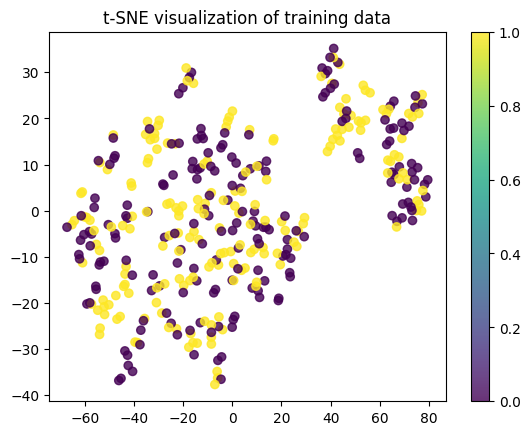

torch.Size([378, 3000, 32])
torch.Size([378, 32])


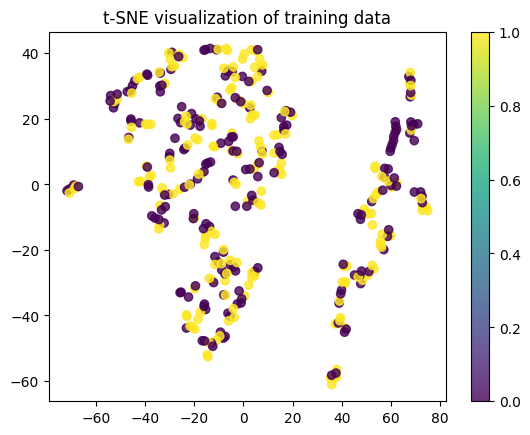

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Streaming output truncated to the last 5000 lines.
1079
torch.Size([32, 1079, 32])
random choose resultion: 64
torch.Size([32, 16, 32])
torch.Size([32, 16, 32])
[[2.64075518]
 [1.74667072]
 [1.19841778]
 [0.71915972]
 [0.37238526]
 [0.17383313]
 [0.1066988 ]
 [0.07712506]
 [0.12049054]
 [0.4840678 ]
 [0.        ]
 [0.        ]]
78
torch.Size([32, 78, 32])
random choose resultion: 1
torch.Size([32, 78, 32])
torch.Size([32, 78, 32])
[[2.67196441]
 [1.82300746]
 [1.18855309]
 [0.63281471]
 [0.29620886]
 [0.12871495]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
2221
torch.Size([32, 2221, 32])
random choose resultion: 4
torch.Size([32, 555, 32])
torch.Size([32, 555, 32])
[[2.72475362]
 [1.81200039]
 [1.2584815 ]
 [0.77469349]
 [0.41351756]
 [0.21423814]
 [0.11815267]
 [0.18727271]
 [0.37803736]
 [0.948035  ]
 [3.35446715]
 [0.        ]]
446
torch.Size([32, 446, 32])
random choose resultion: 2
torch.Size([32, 223, 32])
torch.Size([32, 223, 32])
[[2.672

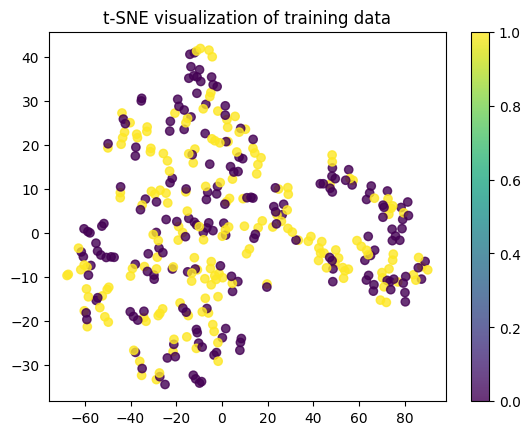

torch.Size([378, 3000, 32])
torch.Size([378, 32])


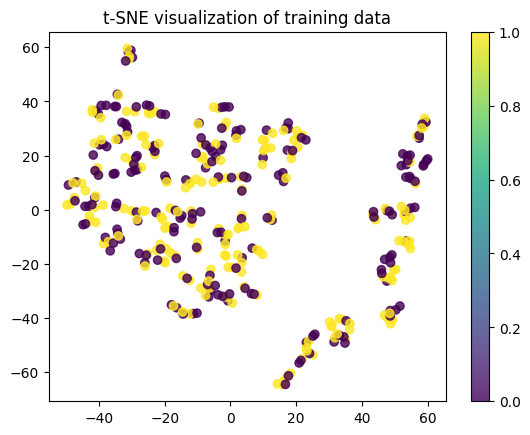

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Streaming output truncated to the last 5000 lines.
1954
torch.Size([32, 1954, 32])
random choose resultion: 128
torch.Size([32, 15, 32])
torch.Size([32, 15, 32])
[[3.05372405]
 [2.05138516]
 [1.42893124]
 [0.94885409]
 [0.58513469]
 [0.33302933]
 [0.21486688]
 [0.31344354]
 [0.74413067]
 [1.89803803]
 [0.        ]
 [0.        ]]
1583
torch.Size([32, 1583, 32])
random choose resultion: 8
torch.Size([32, 197, 32])
torch.Size([32, 197, 32])
[[2.8703022 ]
 [1.93066251]
 [1.34313905]
 [0.87026942]
 [0.51790565]
 [0.30709121]
 [0.19945356]
 [0.31497782]
 [0.48925477]
 [1.31224322]
 [0.        ]
 [0.        ]]
249
torch.Size([32, 249, 32])
random choose resultion: 64
torch.Size([32, 3, 32])
torch.Size([32, 3, 32])
[[2.98854923]
 [1.99776769]
 [1.34139657]
 [0.81260347]
 [0.44638816]
 [0.23387794]
 [0.1121    ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
914
torch.Size([32, 914, 32])
random choose resultion: 8
torch.Size([32, 114, 32])
torch.Size([32, 114, 32])
[[2.7

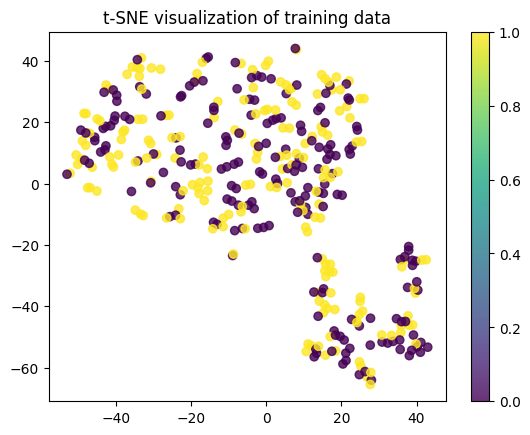

torch.Size([378, 3000, 32])
torch.Size([378, 32])


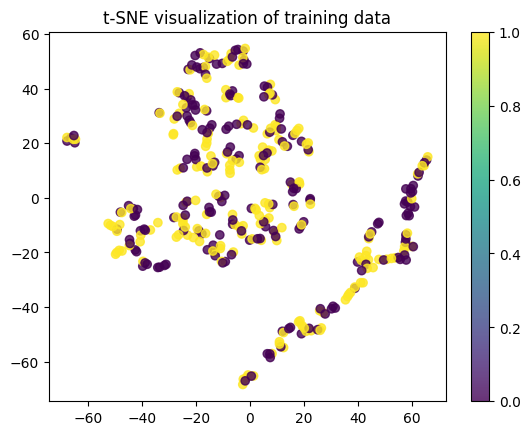

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Streaming output truncated to the last 5000 lines.
2
torch.Size([32, 2, 32])
random choose resultion: 8
torch.Size([32, 1, 32])
torch.Size([32, 1, 32])
[[2.88719082]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
537
torch.Size([32, 537, 32])
random choose resultion: 1
torch.Size([32, 537, 32])
torch.Size([32, 537, 32])
[[3.59354448]
 [2.30772829]
 [1.54482198]
 [1.03845417]
 [0.65517396]
 [0.39149442]
 [0.26086119]
 [0.30744189]
 [0.87126172]
 [0.        ]
 [0.        ]
 [0.        ]]
815
torch.Size([32, 815, 32])
random choose resultion: 8
torch.Size([32, 101, 32])
torch.Size([32, 101, 32])
[[3.86492109]
 [2.59319258]
 [1.78742027]
 [1.24129939]
 [0.85733902]
 [0.58342338]
 [0.45286137]
 [0.5054118 ]
 [0.71156693]
 [0.        ]
 [0.        ]
 [0.        ]]
2157
torch.Size([32, 2157, 32])
random choose resultion: 8
torch.Size([32, 269, 32])
torch.Size([32, 269, 32])
[[3.83505988

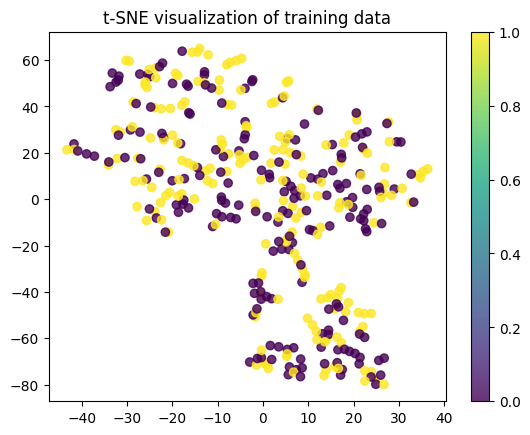

torch.Size([378, 3000, 32])
torch.Size([378, 32])


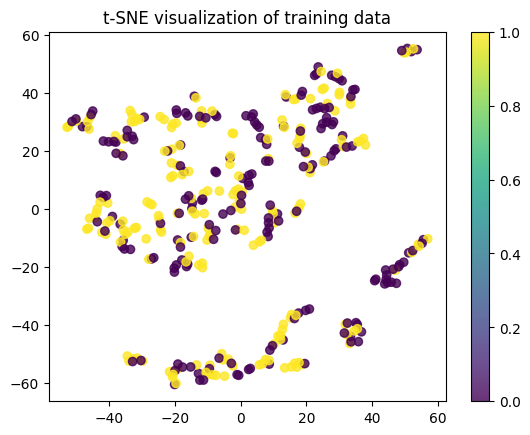

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Streaming output truncated to the last 5000 lines.
1359
torch.Size([32, 1359, 32])
random choose resultion: 64
torch.Size([32, 21, 32])
torch.Size([32, 21, 32])
[[3.42440939]
 [2.47415137]
 [1.87692475]
 [1.46819997]
 [1.11176372]
 [0.80108321]
 [0.6138432 ]
 [0.65052319]
 [0.73481202]
 [1.10149801]
 [0.        ]
 [0.        ]]
800
torch.Size([32, 800, 32])
random choose resultion: 16
torch.Size([32, 50, 32])
torch.Size([32, 50, 32])
[[3.62464619]
 [2.5662148 ]
 [1.89615607]
 [1.46162927]
 [1.11662579]
 [0.83425242]
 [0.73388815]
 [0.83364761]
 [1.00290811]
 [0.        ]
 [0.        ]
 [0.        ]]
205
torch.Size([32, 205, 32])
random choose resultion: 2
torch.Size([32, 102, 32])
torch.Size([32, 102, 32])
[[3.33184004]
 [2.36875868]
 [1.73214102]
 [1.2887795 ]
 [0.9196493 ]
 [0.63631535]
 [0.45331028]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
242
torch.Size([32, 242, 32])
random choose resultion: 32
torch.Size([32, 7, 32])
torch.Size([32, 7, 32])
[[3.80668

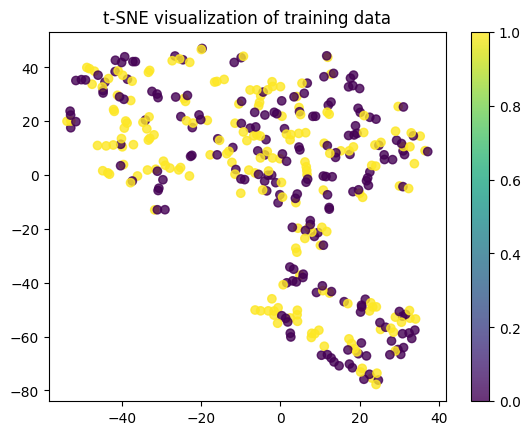

torch.Size([378, 3000, 32])
torch.Size([378, 32])


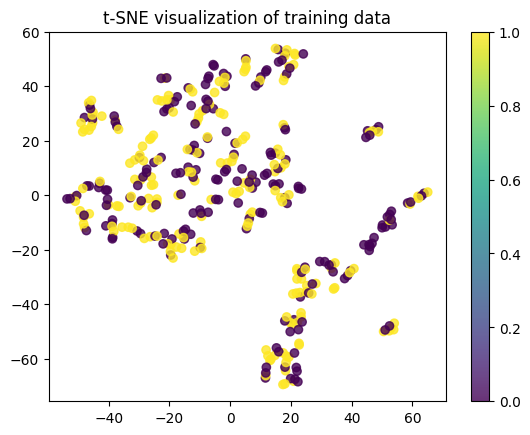

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
import time

#testing 5 times
for experiment in range(5):
    start = time.time()


    net = TSEncoder(input_dims=x.shape[2], output_dims=32, hidden_dims=64, depth=2)
    net = net.cuda()

    res = np.log2(x.shape[1])
    res = res.astype('int')
    optimizer = torch.optim.AdamW(net.parameters(), lr=1e-3)
    total = 0
    avg = 0
    array_loss_proposed = []
    loss_prev = None
    loss_curr = []


    for epoch in range(1000):
        for batch_part in train_dataloader:
            if loss_prev is not None:
                loss_candid = np.concatenate((loss_prev,loss_curr),axis=1).T
                level_sampled = select_res(loss_candid)
                #loss_select = loss_selected_resolution(out1,out2,level_sampled,res=10)
            else:
                level_sampled = np.random.randint(0,res)
            x1,x2,l = cropping(batch_part)
            print(l)
            net.train()
            optimizer.zero_grad()
            out1 = net(x1)
            out2 = net(x2)
            out1 = out1[:,-l:,:]
            out2 = out2[:, :l,:]
            with torch.no_grad():
                loss_value, loss_curr = loss(out1,out2,res=int(np.ceil(np.log2(batch_part.shape[1]))))
            loss_train = loss_selected_resolution(out1,out2,level_sampled,res=10)
            loss_prev = np.copy(loss_curr)
            array_loss_proposed.append(loss_curr)
            loss_train.backward()
            optimizer.step()
            print(loss_curr)
    end = time.time()
    print(end - start)
    running_time = end - start

    #PLOT EMBEDDING
    #####
    #####
    ####
    ###
    import sklearn
    from sklearn.manifold import TSNE
    import numpy as np
    import matplotlib.pylab as plt


#model name is the model used, ts2vec original or proposed
    def tsne_plot(net,x,label,model_name,dir_used,count):
        o = net(x)
        o = o.reshape(x.shape[0],-1)
        #o = o.mean(dim=1)
        print(o.size())

        tsne = TSNE(n_components=2, perplexity=5, random_state=42)
        o = o.squeeze()
        X_train_tsne = tsne.fit_transform(o.cpu().detach().numpy())

        # Data distribution Plotting
        plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=label, alpha=0.8,cmap='viridis')
        plt.title('t-SNE visualization of training data')
        plt.colorbar()

        plt.savefig(f"{dir_used}/tsne_{data_set}_without_pool_{model_name}_{count}.png")

        plt.show()


    def tsne_plot_avg(net,x,label,model_name,dir_used,count):
        o = net(x)
        print(o.shape)
        #o = o.reshape(x.shape[0],-1)
        o = o.mean(dim=1)
        print(o.size())

        tsne = TSNE(n_components=2, perplexity=5, random_state=42)
        o = o.squeeze()
        X_train_tsne = tsne.fit_transform(o.cpu().detach().numpy())

        # Data distribution Plotting
        plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=label, alpha=0.8,cmap='viridis')
        plt.title('t-SNE visualization of training data')
        plt.colorbar()

        plt.savefig(f"{dir_used}/tsne_{data_set}_avgpool_{model_name}_{count}.png")

        plt.show()
        return o

    test_data = np.load('drive/MyDrive/'+data_set+'/X_test.npy')
    test_label = np.load('drive/MyDrive/'+data_set+'/y_test.npy')

    model_used = 'proposed'

    #plot embedding
    test_data_tensor = torch.from_numpy(test_data)
    all_data = torch.cat((x,test_data_tensor.cuda())).float()
    all_label = np.concatenate((train_label,test_label),axis=0)
    #Without average pooling
    tsne_plot(net,all_data,all_label,model_used,fig_dir,experiment)

    #adding code to save this figure



    #tsne_[dataset_name]_without_pool_proposed.png


    #SECOND

    all_repr = tsne_plot_avg(net,all_data,all_label,model_used,fig_dir,experiment)
    #adding code to save this figure


    #tsne_[dataset_name]_avgpool_proposed.png



    #split

    split = x.shape[0]
    train_repr = all_repr[:split,:]
    test_repr = all_repr[split:,:]


    #Accuracy


    import numpy as np
    from sklearn.linear_model import Ridge
    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import make_pipeline
    from sklearn.model_selection import GridSearchCV, train_test_split

    def fit_knn(features, y):
        pipe = make_pipeline(
            StandardScaler(),
            KNeighborsClassifier(n_neighbors=1)
        )
        pipe.fit(features, y)
        return pipe


    def fit_lr(features, y, MAX_SAMPLES=100000):
        # If the training set is too large, subsample MAX_SAMPLES examples
        if features.shape[0] > MAX_SAMPLES:
            split = train_test_split(
                features, y,
                train_size=MAX_SAMPLES, random_state=0, stratify=y
            )
            features = split[0]
            y = split[2]

        pipe = make_pipeline(
            StandardScaler(),
            LogisticRegression(
                random_state=0,
                max_iter=1000000,
                multi_class='ovr'
            )
        )
        pipe.fit(features, y)
        return pipe

    def eval_classification(train_repr, train_labels, test_repr, test_labels, eval_protocol='linear'):
        assert train_labels.ndim == 1 or train_labels.ndim == 2

        #if eval_protocol == 'linear':

        fit_clf = fit_lr

        def merge_dim01(array):
            return array.reshape(array.shape[0]*array.shape[1], *array.shape[2:])
        '''
        if train_labels.ndim == 2:
            train_repr = merge_dim01(train_repr)
            train_labels = merge_dim01(train_labels)
            test_repr = merge_dim01(test_repr)
            test_labels = merge_dim01(test_labels)
        '''

        clf = fit_clf(train_repr, train_labels)

        acc = clf.score(test_repr, test_labels)

        return {'acc': acc}


    #accuracy
    test_repr = test_repr.cpu().detach().numpy()
    train_repr = train_repr.cpu().detach().numpy()
    acc_proposed = eval_classification(train_repr, train_label, test_repr, test_label)

    #keep track of each accuracy per iteration
    proposed_acc_arr.append(acc_proposed)
    proposed_time_arr.append(running_time)

In [ ]:
embed = net(batch_part).mean(dim=1)

In [ ]:
embed = net(x).mean(dim=1)

In [ ]:
M = torch.matmul(embed.transpose(0,1), embed)

In [ ]:
C = torch.cov(embed.transpose(0,1))

In [ ]:
X  = torch.linalg.eig(C)

In [ ]:
torch.log(torch.abs(X.eigenvalues))

tensor([-1.6772, -2.0742, -3.6440, -3.8911, -4.3311, -4.6034, -4.6951, -4.9087,
        -5.1230, -5.4228, -5.4095, -5.6729, -5.7666, -5.9777, -6.2168, -6.1935,
        -6.3859, -6.6056, -6.6391, -6.7936, -6.9423, -8.8969, -8.6443, -8.4318,
        -8.3351, -8.0404, -7.9293, -7.7333, -7.1753, -7.4534, -7.2937, -7.3450],
       device='cuda:0', grad_fn=<LogBackward0>)

torch.Size([378, 96000])


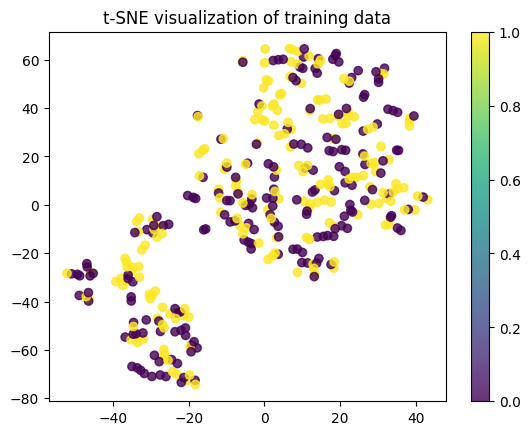

torch.Size([378, 3000, 32])
torch.Size([378, 32])


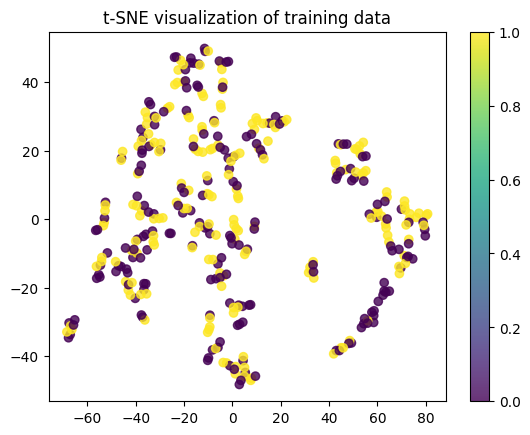

In [ ]:

import sklearn
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pylab as plt

test_data = np.load('drive/MyDrive/'+data_set+'/X_test.npy')
test_label = np.load('drive/MyDrive/'+data_set+'/y_test.npy')

model_used = 'proposed'

def tsne_plot(net,x,label,model_name,dir_used,count):
    o = net(x)
    o = o.reshape(x.shape[0],-1)
    #o = o.mean(dim=1)
    print(o.size())

    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    o = o.squeeze()
    X_train_tsne = tsne.fit_transform(o.cpu().detach().numpy())

    # Data distribution Plotting
    plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=label, alpha=0.8,cmap='viridis')
    plt.title('t-SNE visualization of training data')
    plt.colorbar()

    plt.savefig(f"{dir_used}/tsne_{data_set}_without_pool_{model_name}_{count}.png")

    plt.show()


def tsne_plot_avg(net,x,label,model_name,dir_used,count):
    o = net(x)
    print(o.shape)
    #o = o.reshape(x.shape[0],-1)
    o = o.mean(dim=1)
    print(o.size())

    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    o = o.squeeze()
    X_train_tsne = tsne.fit_transform(o.cpu().detach().numpy())

    # Data distribution Plotting
    plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=label, alpha=0.8,cmap='viridis')
    plt.title('t-SNE visualization of training data')
    plt.colorbar()

    plt.savefig(f"{dir_used}/tsne_{data_set}_avgpool_{model_name}_{count}.png")

    plt.show()
    return o

#plot embedding
test_data_tensor = torch.from_numpy(test_data)
all_data = torch.cat((x,test_data_tensor.cuda())).float()
all_label = np.concatenate((train_label,test_label),axis=0)
#Without average pooling
tsne_plot(net,all_data,all_label,model_used,fig_dir,experiment)

#adding code to save this figure



#tsne_[dataset_name]_without_pool_proposed.png


#SECOND

all_repr = tsne_plot_avg(net,all_data,all_label,model_used,fig_dir,experiment)

In [ ]:
test_repr = net(test_data_tensor.float().cuda()).mean(dim=1)

In [ ]:
#accuracy
test_data = np.load('drive/MyDrive/'+data_set+'/X_test.npy')
test_label = np.load('drive/MyDrive/'+data_set+'/y_test.npy')

model_used = 'proposed'

#plot embedding
test_data_tensor = torch.from_numpy(test_data)
train_repr = net(x).mean(dim=1)
test_repr = net(test_data_tensor.float().cuda()).mean(dim=1)


test_repr = test_repr.cpu().detach().numpy()
train_repr = train_repr.cpu().detach().numpy()
acc_proposed = eval_classification(train_repr, train_label, test_repr, test_label)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
all_data = np.concatenate((train_repr,test_repr),axis=0)

In [ ]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

def fit_lr(features, y, MAX_SAMPLES=100000):
    # If the training set is too large, subsample MAX_SAMPLES examples
    if features.shape[0] > MAX_SAMPLES:
        split = train_test_split(
            features, y,
            train_size=MAX_SAMPLES, random_state=0, stratify=y
        )
        features = split[0]
        y = split[2]

    pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            random_state=0,
            max_iter=1000000,
            multi_class='ovr'
        )
    )
    pipe.fit(features, y)
    return pipe

def eval_classification(train_repr, train_labels, test_repr, test_labels, eval_protocol='linear'):
    assert train_labels.ndim == 1 or train_labels.ndim == 2

    #if eval_protocol == 'linear':

    fit_clf = fit_lr

    def merge_dim01(array):
        return array.reshape(array.shape[0]*array.shape[1], *array.shape[2:])
    '''
    if train_labels.ndim == 2:
        train_repr = merge_dim01(train_repr)
        train_labels = merge_dim01(train_labels)
        test_repr = merge_dim01(test_repr)
        test_labels = merge_dim01(test_labels)
    '''

    clf = fit_clf(train_repr, train_labels)

    acc = clf.score(test_repr, test_labels)

    return {'acc': acc}

#Run Originial ts2vec

Streaming output truncated to the last 5000 lines.
 [0.04426567]
 [0.06964758]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
[[2.2880156 ]
 [1.44485271]
 [0.92046475]
 [0.52390033]
 [0.29186869]
 [0.13205454]
 [0.0645896 ]
 [0.08882169]
 [0.12423888]
 [0.14383993]
 [0.        ]
 [0.        ]]
[[2.27824759]
 [1.44087708]
 [0.9299562 ]
 [0.54670238]
 [0.305206  ]
 [0.14260611]
 [0.088999  ]
 [0.09182107]
 [0.10292408]
 [0.45753986]
 [0.26648307]
 [0.        ]]
[[2.29299879]
 [1.43806112]
 [0.92702663]
 [0.53480047]
 [0.29699418]
 [0.1484057 ]
 [0.1021913 ]
 [0.08822495]
 [0.09424639]
 [0.2251291 ]
 [0.        ]
 [0.        ]]
[[2.33845496]
 [1.47142828]
 [0.9354102 ]
 [0.53562742]
 [0.28807554]
 [0.13431895]
 [0.06205359]
 [0.0640997 ]
 [0.13936631]
 [0.24170791]
 [0.        ]
 [0.        ]]
[[2.32372427]
 [1.46507037]
 [0.95450026]
 [0.5589022 ]
 [0.30556202]
 [0.1611487 ]
 [0.09541897]
 [0.12993272]
 [0.21179542]
 [0.40864351]
 [0.70174539]
 [0.        ]]
[[2.4160409 ]
 [1.5

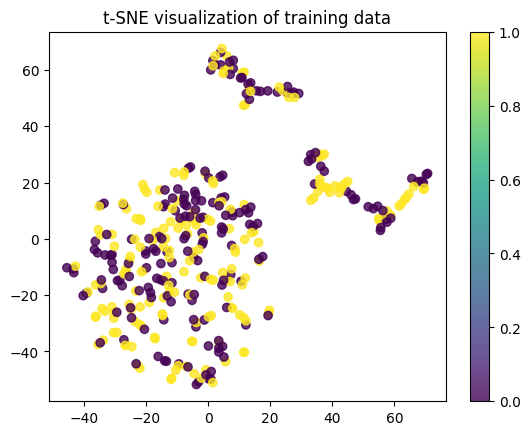

torch.Size([378, 3000, 32])
torch.Size([378, 32])


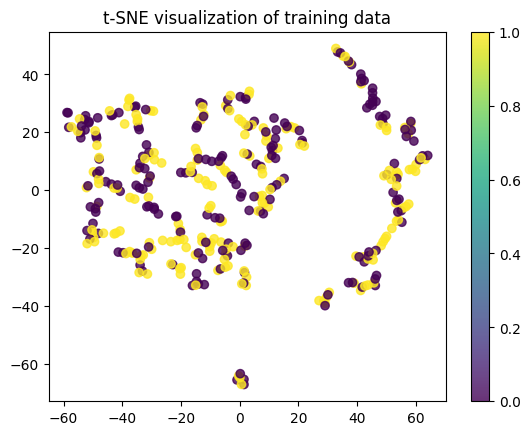

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Streaming output truncated to the last 5000 lines.
 [0.08167768]
 [0.10658408]
 [0.07037256]
 [0.        ]
 [0.        ]
 [0.        ]]
[[2.26882935]
 [1.44328356]
 [0.90808529]
 [0.46050236]
 [0.19378145]
 [0.08110689]
 [0.03037233]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
[[2.36558676]
 [1.50853884]
 [0.97292966]
 [0.54690355]
 [0.27643928]
 [0.12927043]
 [0.05542805]
 [0.03178591]
 [0.04367284]
 [0.10999499]
 [0.        ]
 [0.        ]]
[[2.41728497]
 [1.5216769 ]
 [0.98939097]
 [0.56760317]
 [0.31448111]
 [0.15912345]
 [0.09209234]
 [0.12343283]
 [0.15130471]
 [0.17790909]
 [0.31324607]
 [0.        ]]
[[2.28656936]
 [1.45427537]
 [0.93563658]
 [0.5122112 ]
 [0.25286481]
 [0.11079667]
 [0.05669961]
 [0.06961053]
 [0.21590957]
 [0.1894763 ]
 [0.        ]
 [0.        ]]
[[2.15794206]
 [1.36679387]
 [0.86594117]
 [0.43736538]
 [0.19497411]
 [0.08313909]
 [0.05364205]
 [0.0810987 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
[[2.38837624]
 [1.5

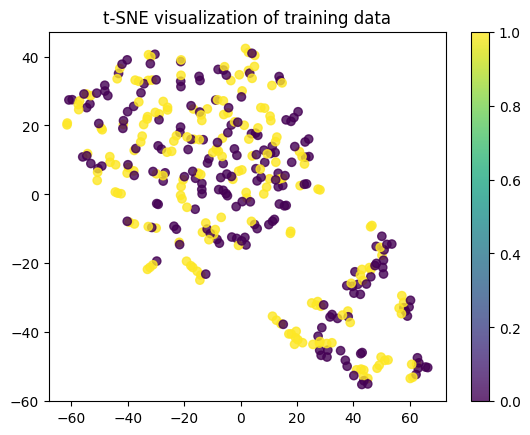

torch.Size([378, 3000, 32])
torch.Size([378, 32])


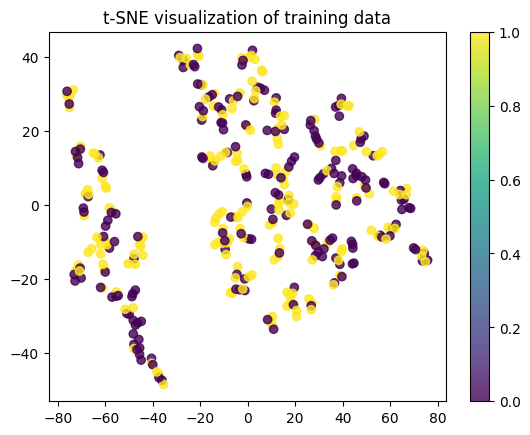

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Streaming output truncated to the last 5000 lines.
 [0.03560537]
 [0.04129157]
 [0.03973117]
 [0.        ]
 [0.        ]
 [0.        ]]
[[2.18684745]
 [1.31973755]
 [0.78639019]
 [0.38867897]
 [0.19325596]
 [0.0796793 ]
 [0.02710295]
 [0.05864161]
 [0.03861153]
 [0.        ]
 [0.        ]
 [0.        ]]
[[2.23962188]
 [1.37215447]
 [0.86126864]
 [0.45735562]
 [0.23771526]
 [0.1062243 ]
 [0.05420084]
 [0.07477807]
 [0.09879449]
 [0.12325466]
 [0.21757635]
 [0.        ]]
[[2.21476531]
 [1.33869517]
 [0.81004506]
 [0.41418287]
 [0.22077496]
 [0.12059238]
 [0.04768834]
 [0.04960402]
 [0.09456079]
 [0.05314183]
 [0.        ]
 [0.        ]]
[[2.14246988]
 [1.31008923]
 [0.76483095]
 [0.34548652]
 [0.15299319]
 [0.07707078]
 [0.02809278]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
[[2.29522657]
 [1.38987684]
 [0.86804706]
 [0.46642366]
 [0.25003293]
 [0.13470149]
 [0.07740483]
 [0.10423505]
 [0.13671984]
 [0.11497462]
 [0.38114044]
 [0.        ]]
[[2.19230628]
 [1.3

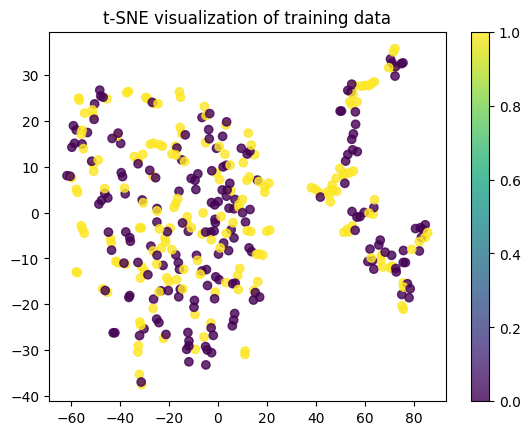

torch.Size([378, 3000, 32])
torch.Size([378, 32])


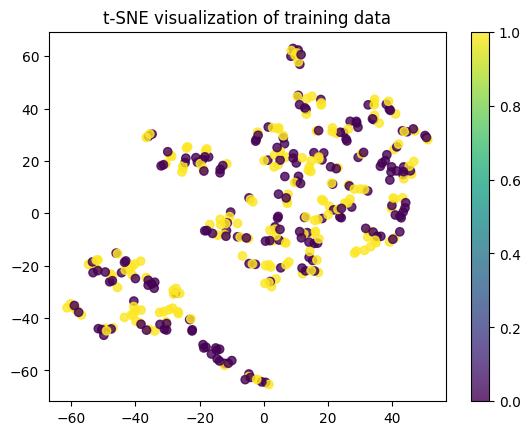

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Streaming output truncated to the last 5000 lines.
 [0.02814505]
 [0.03816475]
 [0.02509635]
 [0.        ]
 [0.        ]
 [0.        ]]
[[2.05466723]
 [1.20026374]
 [0.67227787]
 [0.34344518]
 [0.2108435 ]
 [0.11319733]
 [0.05300012]
 [0.05531633]
 [0.06497319]
 [0.16371593]
 [0.        ]
 [0.        ]]
[[2.04292989]
 [1.19616449]
 [0.66303611]
 [0.34622255]
 [0.21177433]
 [0.09597356]
 [0.05120336]
 [0.05281133]
 [0.03383896]
 [0.13986437]
 [0.        ]
 [0.        ]]
[[2.10836291]
 [1.23368227]
 [0.69213057]
 [0.33539322]
 [0.1707895 ]
 [0.09232376]
 [0.05200603]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
[[2.11404228]
 [1.23422801]
 [0.69856602]
 [0.36991808]
 [0.23442221]
 [0.1543493 ]
 [0.08816991]
 [0.09278113]
 [0.13094503]
 [0.17919001]
 [0.2109728 ]
 [0.        ]]
[[2.10129356]
 [1.23039484]
 [0.69004393]
 [0.35313678]
 [0.20198818]
 [0.08925831]
 [0.05268865]
 [0.07173728]
 [0.11122465]
 [0.19713101]
 [0.        ]
 [0.        ]]
[[2.09653211]
 [1.2

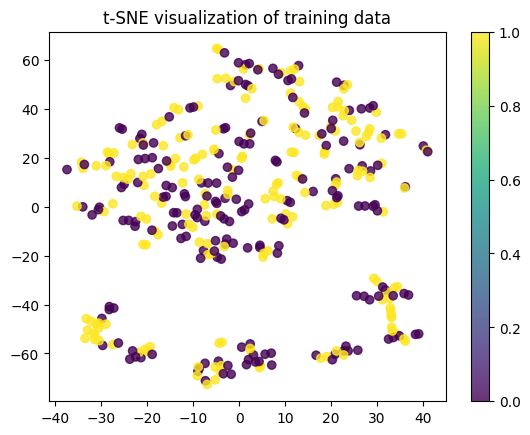

torch.Size([378, 3000, 32])
torch.Size([378, 32])


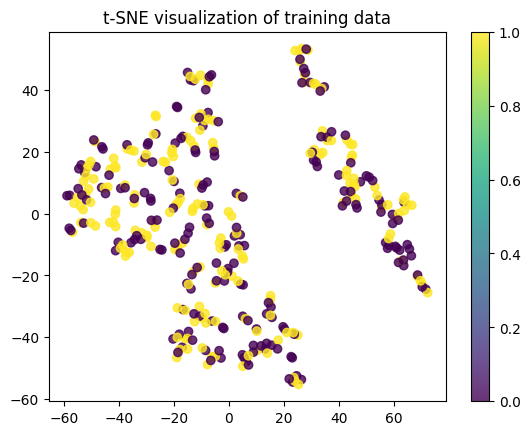

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Streaming output truncated to the last 5000 lines.
 [0.06547222]
 [0.0843724 ]
 [0.12170783]
 [0.27536896]
 [0.        ]
 [0.        ]]
[[2.37368965]
 [1.52608562]
 [0.99950796]
 [0.56899011]
 [0.30777812]
 [0.15810779]
 [0.09443794]
 [0.18045412]
 [0.4115445 ]
 [0.        ]
 [0.        ]
 [0.        ]]
[[2.25979805]
 [1.46464002]
 [0.93260938]
 [0.44179448]
 [0.1866371 ]
 [0.06658012]
 [0.01544563]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
[[2.39438534]
 [1.51531994]
 [0.9868803 ]
 [0.56560194]
 [0.30357656]
 [0.14076748]
 [0.08447303]
 [0.09935497]
 [0.18731718]
 [0.22221602]
 [0.        ]
 [0.        ]]
[[2.24871802]
 [1.43088758]
 [0.92916113]
 [0.51593363]
 [0.27515072]
 [0.12024756]
 [0.05731412]
 [0.08272795]
 [0.11435319]
 [0.2329291 ]
 [0.        ]
 [0.        ]]
[[2.27346826]
 [1.4443382 ]
 [0.9257468 ]
 [0.50246143]
 [0.25763327]
 [0.10742114]
 [0.05119142]
 [0.05684013]
 [0.05956512]
 [0.        ]
 [0.        ]
 [0.        ]]
[[2.31720066]
 [1.4

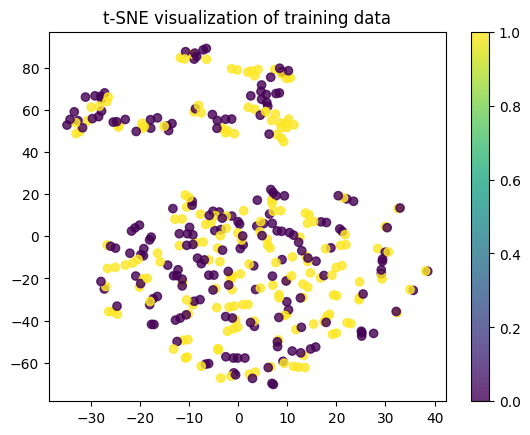

torch.Size([378, 3000, 32])
torch.Size([378, 32])


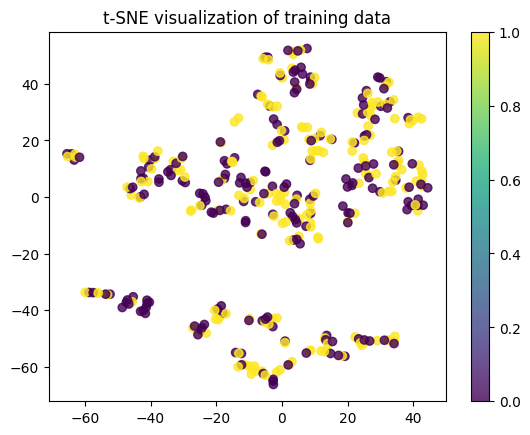

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
original_acc_arr = []
original_time_arr = []

import time

fig_dir_ts2vec = '/content/drive/MyDrive/experiment_figures_TS2Vec/' + data_set
model_used = 'ts2vec'

for original_experiment in range(5):
    start = time.time()
    net2 = TSEncoder(input_dims=x.shape[2], output_dims=32, hidden_dims=64, depth=2)
    net2 = net2.cuda()

    res = np.log2(x.shape[1])
    res = res.astype('int')
    optimizer = torch.optim.AdamW(net2.parameters(), lr=1e-3)
    total = 0
    avg = 0
    array_loss_all = []
    prev_resolution_loss = None
    curr_resolution_loss = []
    for i in range(1000):
        for batch_part in train_dataloader:
            net.train()
            optimizer.zero_grad()
            x1,x2,l = cropping(batch_part)
            #x1 = x1.cuda()
            #x2 = x2.cuda()
            out1 = net2(x1)
            out2 = net2(x2)
            out1 = out1[:,-l:,:]
            out2 = out2[:, :l,:]
            #changed res to res-1 due to out of bounds error, size 9 but trying to reach index 9 rather than 8.
            #l_h = loss_random(out1,out2,None,10)
            #with torch.no_grad():
            lss, curr_resolution_loss = loss(out1,out2,res=int(np.ceil(np.log2(batch_part.shape[1]))))


                #flip loss and align
                #fill zero
                #compute score
                #pick resolution
                #switch back to original idxlo
                #compute loss_select


            lss.backward()
            #l_h.backward()
            #loss_select.backward()
            optimizer.step()
            #prev_resolution_loss = np.copy(curr_resolution_loss)
            #with torch.no_grad():
            print(curr_resolution_loss)
            array_loss_all.append(curr_resolution_loss)



        #with torch.no_grad():


        #print('loss value: '+str(l_h.item()))

    end = time.time()
    print(end - start)
    running_time_original = end-start

    # #plot embedding
    test_data_tensor = torch.from_numpy(test_data)
    all_data = torch.cat((x,test_data_tensor.cuda())).float()
    all_label = np.concatenate((train_label,test_label),axis=0)
    #Without average pooling

    # all_data = torch.from_numpy(all_data).cuda()
    # all_label = torch.from_numpy(all_label).cuda()

    tsne_plot(net2,all_data,all_label,model_used,fig_dir_ts2vec,original_experiment)
    #adding code to save this figure
    #tsne_[dataset_name]_without_pool_original.png

    all_repr = tsne_plot_avg(net2,all_data,all_label,model_used,fig_dir_ts2vec,original_experiment)
    #adding code to save this figure
    #tsne_[dataset_name]_avgpool_original.png

    split = x.shape[0]
    train_repr = all_repr[:split,:]
    test_repr = all_repr[split:,:]

    test_repr = test_repr.cpu().detach().numpy()
    train_repr = train_repr.cpu().detach().numpy()
    acc_orig = eval_classification(train_repr, train_label, test_repr, test_label)

    original_acc_arr.append(acc_orig)
    original_time_arr.append(running_time_original)

In [ ]:
all_data.shape

torch.Size([378, 3000, 64])

In [ ]:
all_label.shape

(378, 1)

#proposed accuracy and time

In [ ]:
print(proposed_acc_arr)
print(proposed_time_arr)

[{'acc': 0.46}, {'acc': 0.53}, {'acc': 0.51}, {'acc': 0.49}, {'acc': 0.4}]
[1388.4382319450378, 1529.567052602768, 1567.9730432033539, 1585.2769927978516, 1607.070457458496]


#original accuracy and time


In [ ]:
print(original_acc_arr)
print(original_time_arr)

[{'acc': 0.5}, {'acc': 0.52}, {'acc': 0.49}, {'acc': 0.55}, {'acc': 0.5}]
[2026.2492425441742, 2024.5816779136658, 2015.7565047740936, 2090.1784162521362, 2199.94251036644]
